In [1]:
# --- imports
import os, sys, shutil
from pathlib import Path
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from pathlib import Path
from LATSourceModel import SourceList
from make4FGLxml import *
from xml.etree import ElementTree as ET
# Fermitools python apps
import gt_apps as my_apps
from UnbinnedAnalysis import UnbinnedObs, UnbinnedAnalysis
from UpperLimits import UpperLimits

# If you also use LATSourceModel / make4FGLxml:
try:
    from LATSourceModel import SourceList
except Exception:
    SourceList = None  # optional; we'll show a pure-XML fallback too

# ---- user-config (EDIT THESE)
SRC_NAME   = "GRB200415A"
SRC_RA     = 11.888058       # deg
SRC_DEC    = -25.288800      # deg

# 500 s window around T0
T0         = 608633290.563746 #608633290.564
TMIN       = T0
TMAX       = T0 + 500.0

ROI_DEG    = 12.0
EMIN_MEV   = 100.0
EMAX_MEV   = 100000.0 #Keep up to 100 GeV only 
ZMAX       = 100.0

# Choose one consistent mode; we use TRANSIENT020E for short window
EVCLASS    = 8               # P8R3_TRANSIENT class bit
EVTYPE     = 3               # FRONT+BACK
IRFS       = "P8R3_TRANSIENT020E_V3"
ISO_BASENAME = "iso_P8R3_TRANSIENT020E_V3_v1.txt"

# Paths (EDIT: base folder with your FT1/FT2)
BASE = Path("/Users/salim/Desktop/MGFs_LAT/MGF_LAT_analysis_trigger/GRB_200415A").expanduser()
FT1  = BASE / "L250924144758039FD35863_EV00.fits"  # FT1
FT2  = BASE / "L250924144758039FD35863_SC00.fits"  # FT2

# Output dir for this single-example run
OUT  = BASE / "GRB200415A_Analysis" # Results are stored in 
OUT.mkdir(parents=True, exist_ok=True)

FT1_FILT = OUT / "filtered_evts.fits"
FT1_MKT  = OUT / "filtered_gti.fits"
LTCUBE   = OUT / "ltcube.fits"
EXPMAP   = OUT / "expmap.fits"

# Model files (no-GRB and with-GRB)
XML_NOGRB_psc22 = OUT / "model_without_grb_psc22.xml"
XML_WITH  = OUT / "model_with_grb.xml"

# TS map (no GRB in model)
TSMAP_NOGRB = OUT / "tsmap_nogrb.fits"

# Diffuse templates from FERMI_DIR
FERMI_DIR = Path(os.environ["FERMI_DIR"])
DIFF_GAL  = FERMI_DIR / "refdata/fermi/galdiffuse/gll_iem_v07.fits"
DIFF_ISO  = FERMI_DIR / f"refdata/fermi/galdiffuse/{ISO_BASENAME}"

# Sanity checks
assert FT1.exists(), f"Missing FT1: {FT1}"
assert FT2.exists(), f"Missing FT2: {FT2}"
assert DIFF_GAL.exists(), f"Missing Galactic diffuse: {DIFF_GAL}"
assert DIFF_ISO.exists(), f"Missing ISO diffuse: {DIFF_ISO}"

print("Config OK. Outputs ->", OUT)

# Check FT1 time/energy coverage roughly spans your window
with fits.open(FT1) as h:
    tmin_h, tmax_h = h[1].header['TSTART'], h[1].header['TSTOP']
    print(f"FT1 covers: [{tmin_h:.1f}, {tmax_h:.1f}] (we need [{TMIN:.1f}, {TMAX:.1f}])")

# Confirm SC file spans window too
with fits.open(FT2) as h:
    print(f"FT2 covers: [{h[1].header['TSTART']:.1f}, {h[1].header['TSTOP']:.1f}]")

# Ensure CALDB is visible (IRF lookup will fail otherwise)
assert os.environ.get("CALDB"), "CALDB not set; export CALDB before running Fermitools."



This is make4FGLDR3xml version 01r09.
The default diffuse model files and names are for P8R3, 4FGL DRs, and the default fermitools directory locations.
Config OK. Outputs -> /Users/salim/Desktop/MGFs_LAT/MGF_LAT_analysis_trigger/GRB_200415A/GRB200415A_Analysis
FT1 covers: [608533290.0, 609633290.0] (we need [608633290.6, 608633790.6])
FT2 covers: [608533290.0, 609633290.0]


In [2]:
def gtselect_filter_events(ifl, gtselect_outfile, evclass, evtype, ra, dec, rad,
                           tmin, tmax, emin, emax, zmin, zmax):
    my_apps.filter['infile']  = str(ifl)
    my_apps.filter['outfile'] = str(gtselect_outfile)
    my_apps.filter['evclass'] = int(evclass)
    my_apps.filter['evtype']  = int(evtype)
    my_apps.filter['ra']      = float(ra)
    my_apps.filter['dec']     = float(dec)
    my_apps.filter['rad']     = float(rad)
    my_apps.filter['tmin']    = float(tmin)
    my_apps.filter['tmax']    = float(tmax)
    my_apps.filter['emin']    = float(emin)
    my_apps.filter['emax']    = float(emax)
    my_apps.filter['zmin']    = float(zmin)
    my_apps.filter['zmax']    = float(zmax)
    print("[gtselect]", my_apps.filter.command())
    my_apps.filter.run()
    return gtselect_outfile


def gtmaketime_events(scfile, evfile, gtmaketime_ofl, ra_src, dec_src, roi_deg, zmax_deg):
    # Scheme A: ANGSEP<=zmax-ROI enforced in GTIs; later we set ltcube zmax=180
    filt = ("(DATA_QUAL>0)&&(LAT_CONFIG==1)&&(IN_SAA==F)&&(LIVETIME>0)&&"
            f"(ANGSEP(RA_ZENITH,DEC_ZENITH,{ra_src:.6f},{dec_src:.6f})<={zmax_deg - roi_deg:.1f})")
    my_apps.maketime['scfile']   = str(scfile)
    my_apps.maketime['sctable']  = "SC_DATA"
    my_apps.maketime['filter']   = filt
    my_apps.maketime['roicut']   = "no"
    my_apps.maketime['evfile']   = str(evfile)
    my_apps.maketime['evtable']  = "EVENTS"
    my_apps.maketime['outfile']  = str(gtmaketime_ofl)
    print("[gtmktime]", my_apps.maketime.command())
    my_apps.maketime.run()
    return gtmaketime_ofl


def gt_ltcube(scfile, evfile, ltcube_outfile):
    my_apps.expCube['evfile']    = str(evfile)
    my_apps.expCube['scfile']    = str(scfile)
    my_apps.expCube['outfile']   = str(ltcube_outfile)
    my_apps.expCube['zmax']      = 180.0        # since limb handled at GTI stage
    my_apps.expCube['dcostheta'] = 0.025
    my_apps.expCube['binsz']     = 1.0
    print("[gtltcube]", my_apps.expCube.command())
    my_apps.expCube.run()
    return ltcube_outfile


def exp_map(expmap_input_ifl, scfile, ltcube_file, expmap_outfile, irf):
    my_apps.expMap['evfile']    = str(expmap_input_ifl)
    my_apps.expMap['scfile']    = str(scfile)
    my_apps.expMap['expcube']   = str(ltcube_file)
    my_apps.expMap['outfile']   = str(expmap_outfile)
    my_apps.expMap['irfs']      = str(irf)
    my_apps.expMap['srcrad']    = 24.0     # good for 12° ROI at 100 MeV
    my_apps.expMap['nlong']     = 48
    my_apps.expMap['nlat']      = 48
    my_apps.expMap['nenergies'] = 20
    print("[gtexpmap]", my_apps.expMap.command())
    my_apps.expMap.run()
    return expmap_outfile



def diff_rsp(diffrsp_evfile, scfile, srcmdl, irf):
    my_apps.diffResps['evfile']  = str(diffrsp_evfile)
    my_apps.diffResps['scfile']  = str(scfile)
    my_apps.diffResps['srcmdl']  = str(srcmdl)
    my_apps.diffResps['irfs']    = str(irf)
    my_apps.diffResps['evtable'] = "EVENTS"
    my_apps.diffResps['sctable'] = "SC_DATA"
    print("[gtdiffrsp]", my_apps.diffResps.command())
    my_apps.diffResps.run()



In [3]:
# 1) gtselect
_ = gtselect_filter_events(
    ifl=FT1, gtselect_outfile=FT1_FILT, evclass=EVCLASS, evtype=EVTYPE,
    ra=SRC_RA, dec=SRC_DEC, rad=ROI_DEG, tmin=TMIN, tmax=TMAX,
    emin=EMIN_MEV, emax=EMAX_MEV, zmin=0.0, zmax=ZMAX
)

# Quick count
with fits.open(FT1_FILT) as h:
    n_events = h['EVENTS'].header.get('NAXIS2', len(h['EVENTS'].data))
print("\n Selected events:", n_events)

# 2) gtmktime (ANGSEP scheme)
_ = gtmaketime_events(
    scfile=FT2, evfile=FT1_FILT, gtmaketime_ofl=FT1_MKT,
    ra_src=SRC_RA, dec_src=SRC_DEC, roi_deg=ROI_DEG, zmax_deg=ZMAX
)

# Count again after GTIs
with fits.open(FT1_MKT) as h:
    n_events2 = h['EVENTS'].header.get('NAXIS2', len(h['EVENTS'].data))
print("Events after GTIs:", n_events2)


[gtselect] time -p gtselect infile=/Users/salim/Desktop/MGFs_LAT/MGF_LAT_analysis_trigger/GRB_200415A/L250924144758039FD35863_EV00.fits outfile=/Users/salim/Desktop/MGFs_LAT/MGF_LAT_analysis_trigger/GRB_200415A/GRB200415A_Analysis/filtered_evts.fits ra=11.888058 dec=-25.2888 rad=12.0 tmin=608633290.563746 tmax=608633790.563746 emin=100.0 emax=100000.0 zmin=0.0 zmax=100.0 evclass=8 evtype=3 convtype=-1 phasemin=0.0 phasemax=1.0 evtable="EVENTS" chatter=2 clobber=yes debug=no gui=no mode="ql"
time -p gtselect infile=/Users/salim/Desktop/MGFs_LAT/MGF_LAT_analysis_trigger/GRB_200415A/L250924144758039FD35863_EV00.fits outfile=/Users/salim/Desktop/MGFs_LAT/MGF_LAT_analysis_trigger/GRB_200415A/GRB200415A_Analysis/filtered_evts.fits ra=11.888058 dec=-25.2888 rad=12.0 tmin=608633290.563746 tmax=608633790.563746 emin=100.0 emax=100000.0 zmin=0.0 zmax=100.0 evclass=8 evtype=3 convtype=-1 phasemin=0.0 phasemax=1.0 evtable="EVENTS" chatter=2 clobber=yes debug=no gui=no mode="ql"
Done.
real 0.07
use

In [4]:
# 3) gtltcube
_ = gt_ltcube(FT2, FT1_MKT, LTCUBE)

# 4) gtdiffrsp (for unbinned fits)
# We'll run it twice: once for the no-GRB model XML, once more later if we alter the model.
# For now we need a model XML; we'll build a minimal "no-GRB" model next, then call diffRsp.

print("Exposure cube done.")


[gtltcube] time -p gtltcube evfile="/Users/salim/Desktop/MGFs_LAT/MGF_LAT_analysis_trigger/GRB_200415A/GRB200415A_Analysis/filtered_gti.fits" evtable="EVENTS" scfile=/Users/salim/Desktop/MGFs_LAT/MGF_LAT_analysis_trigger/GRB_200415A/L250924144758039FD35863_SC00.fits sctable="SC_DATA" outfile=/Users/salim/Desktop/MGFs_LAT/MGF_LAT_analysis_trigger/GRB_200415A/GRB200415A_Analysis/ltcube.fits dcostheta=0.025 binsz=1.0 phibins=0 tmin=0.0 tmax=0.0 file_version="1" zmin=0.0 zmax=180.0 chatter=2 clobber=yes debug=no gui=no mode="ql"
time -p gtltcube evfile="/Users/salim/Desktop/MGFs_LAT/MGF_LAT_analysis_trigger/GRB_200415A/GRB200415A_Analysis/filtered_gti.fits" evtable="EVENTS" scfile=/Users/salim/Desktop/MGFs_LAT/MGF_LAT_analysis_trigger/GRB_200415A/L250924144758039FD35863_SC00.fits sctable="SC_DATA" outfile=/Users/salim/Desktop/MGFs_LAT/MGF_LAT_analysis_trigger/GRB_200415A/GRB200415A_Analysis/ltcube.fits dcostheta=0.025 binsz=1.0 phibins=0 tmin=0.0 tmax=0.0 file_version="1" zmin=0.0 zmax=180

In [5]:
from pathlib import Path
import xml.etree.ElementTree as ET

# --- define the missing vars in THIS notebook scope ---
CATALOG = Path("/Users/salim/Desktop/MGFs_LAT/MGF_LAT_analysis_trigger/gll_psc_v35.fit")
assert CATALOG.exists(), f"Missing 4FGL DR-4 catalog: {CATALOG}"


# Output XMLs
XML_NOGRB_psc35 = OUT / "model_without_grb_psc35.xml"
XML_WITH        = OUT / "model_with_grb.xml"

# Sanity: diffuse files & event file must exist
assert Path(DIFF_GAL).exists() and Path(DIFF_ISO).exists()
assert Path(FT1_MKT).exists()


In [6]:
from LATSourceModel import SourceList
from pathlib import Path
import xml.etree.ElementTree as ET

# Paths you already defined
# CATALOG = Path("/.../gll_psc_v35.fit")
# DIFF_GAL, DIFF_ISO, FT1_MKT, OUT
XML_NOGRB_psc35 = OUT / "model_without_grb_psc35.xml"
XML_WITH        = OUT / "model_with_grb.xml"


# Analysis band / spectral setup (PowerLaw2 defined over [emin, emax])
ANALYSIS = {
    "emin": float(EMIN_MEV),   # MeV
    "emax": float(EMAX_MEV),   # MeV
    "spectral_index": -2.0,     # start value; you can free/refit later
}
# --- Build base XML (catalog + diffuse), with no catalog sources auto-freed
sl = SourceList(
    catalog_file=str(CATALOG),    # <-- THIS must be the 4FGL catalog (gll_psc_v35.fit)
    ROI=str(FT1_MKT),             # infer ROI from your GTI-cut FT1
    output_name=XML_NOGRB_psc35.name,
    DR=4,
    write_directory=str(OUT),
)

sl.make_model(
    galactic_file=str(DIFF_GAL),
    galactic_name="gll_iem_v07",
    isotropic_file=str(DIFF_ISO),
    isotropic_name="iso_diffuse",
    norms_free_only=False,   # don’t auto-free neighbor norms
    free_radius=0.0,         # disable radius-based freeing
    max_free_radius=0.0,
    sigma_to_free=1e9,       # disable sigma-based freeing
    variable_free=False,     # don’t auto-free variable sources
    make_region=True,
)

print(f"[write] {XML_NOGRB_psc35}")

# --- Append the GRB as a PL2 over the full analysis band; free for global fit
# NOTE: For PowerLaw2, the Index is the positive spectral index (Γ), so 2.0 is fine.
spectrum_info = {
    "model": "PowerLaw2",
    "Integral": 1e-6,                    # starting guess (ph cm^-2 s^-1 over [emin,emax])
    "Integral_free": True,
    "Index": float(ANALYSIS.get("spectral_index", -2.0)),  # Γ; 2.0 is typical
    "Index_free": True,                  # free in global fit; we’ll fix per-bin later
    "LowerLimit": float(ANALYSIS["emin"]),
    "LowerLimit_free": False,
    "UpperLimit": float(ANALYSIS["emax"]),
    "UpperLimit_free": False,
}

# Reuse the same SourceList to add a point source starting from the base XML
sl = SourceList(
    catalog_file=str(CATALOG),
    ROI=str(FT1_MKT),
    output_name=XML_NOGRB_psc35.name,
    DR=4,
    write_directory=str(OUT),
)

sl.add_point_source(
    source_name=SRC_NAME,               # e.g. "FXT_transient" / "GRB200415A"
    RA=float(SRC_RA),
    DEC=float(SRC_DEC),
    spectrum_model=spectrum_info,
    new_model_name=XML_WITH.name,       # write a separate XML with the GRB
    overwrite=True,
    update_reg=True,
)

print("✓ wrote model with GRB:", XML_WITH)

# Quick sanity check
root  = ET.parse(XML_WITH).getroot()
names = [s.attrib.get("name","") for s in root.findall(".//source")]
print("Contains GRB entry:", any(n == SRC_NAME for n in names))
print("Has Galactic diffuse:", "gll_iem_v07" in names)
print("Has ISO diffuse:", "iso_diffuse" in names)


Creating spatial and spectral model from the 4FGL DR-4 catalog: /Users/salim/Desktop/MGFs_LAT/MGF_LAT_analysis_trigger/gll_psc_v35.fit.
Added 219 point sources and 0 extended sources.
Building ds9-style region file...done!
File saved as /Users/salim/Desktop/MGFs_LAT/MGF_LAT_analysis_trigger/GRB_200415A/GRB200415A_Analysis/ROI_model_without_grb_psc35.reg.
[write] /Users/salim/Desktop/MGFs_LAT/MGF_LAT_analysis_trigger/GRB_200415A/GRB200415A_Analysis/model_without_grb_psc35.xml
GRB200415A added to model, saved as /Users/salim/Desktop/MGFs_LAT/MGF_LAT_analysis_trigger/GRB_200415A/GRB200415A_Analysis/model_with_grb.xml
SourceList object attribute "output_name" now points to new file
✓ wrote model with GRB: /Users/salim/Desktop/MGFs_LAT/MGF_LAT_analysis_trigger/GRB_200415A/GRB200415A_Analysis/model_with_grb.xml
Contains GRB entry: True
Has Galactic diffuse: True
Has ISO diffuse: True


/Users/salim/anaconda3/envs/fermi_env/lib/python3.9/site-packages/LATSourceModel/SourceList.py:154: UserWarning: Region XML model /Users/salim/Desktop/MGFs_LAT/MGF_LAT_analysis_trigger/GRB_200415A/GRB200415A_Analysis/model_without_grb_psc35.xml already exists, will be overwritten if you call the make_model method.
  warnings.warn(f'Region XML model {str(self.output_name)} already exists, will be\
/Users/salim/anaconda3/envs/fermi_env/lib/python3.9/site-packages/LATSourceModel/SourceList.py:285: UserWarning: max_free_radius (0.0) is < free_radius (0.0), making the parameter useless.
  warnings.warn(f'max_free_radius ({max_free_radius:.1f}) is < free_radius ({free_radius:.1f}), making the parameter useless.')
/Users/salim/anaconda3/envs/fermi_env/lib/python3.9/site-packages/LATSourceModel/SourceList.py:154: UserWarning: Region XML model /Users/salim/Desktop/MGFs_LAT/MGF_LAT_analysis_trigger/GRB_200415A/GRB200415A_Analysis/model_without_grb_psc35.xml already exists, will be overwritten if

In [7]:
# Unbinned exposure map (keep IRFs consistent!)
_ = exp_map(expmap_input_ifl=FT1_MKT, scfile=FT2, ltcube_file=LTCUBE,
            expmap_outfile=EXPMAP, irf=IRFS)


# Diffuse responses for the EXACT FT1 you're fitting (post-gtmktime) with the *_nosrc.xml
diff_rsp(FT1_MKT, FT2, XML_WITH, IRFS)


print("gtexpmap + gtdiffrsp done")


[gtexpmap] time -p gtexpmap evfile=/Users/salim/Desktop/MGFs_LAT/MGF_LAT_analysis_trigger/GRB_200415A/GRB200415A_Analysis/filtered_gti.fits evtable="EVENTS" scfile=/Users/salim/Desktop/MGFs_LAT/MGF_LAT_analysis_trigger/GRB_200415A/L250924144758039FD35863_SC00.fits sctable="SC_DATA" expcube=/Users/salim/Desktop/MGFs_LAT/MGF_LAT_analysis_trigger/GRB_200415A/GRB200415A_Analysis/ltcube.fits outfile=/Users/salim/Desktop/MGFs_LAT/MGF_LAT_analysis_trigger/GRB_200415A/GRB200415A_Analysis/expmap.fits irfs="P8R3_TRANSIENT020E_V3" evtype="INDEF" srcrad=24.0 nlong=48 nlat=48 nenergies=20 submap=no nlongmin=0 nlongmax=0 nlatmin=0 nlatmax=0 chatter=2 clobber=yes debug=no gui=no mode="ql"
time -p gtexpmap evfile=/Users/salim/Desktop/MGFs_LAT/MGF_LAT_analysis_trigger/GRB_200415A/GRB200415A_Analysis/filtered_gti.fits evtable="EVENTS" scfile=/Users/salim/Desktop/MGFs_LAT/MGF_LAT_analysis_trigger/GRB_200415A/L250924144758039FD35863_SC00.fits sctable="SC_DATA" expcube=/Users/salim/Desktop/MGFs_LAT/MGF_LAT

In [8]:
from UnbinnedAnalysis import UnbinnedObs, UnbinnedAnalysis
obs_grb  = UnbinnedObs(str(FT1_MKT), str(FT2),
                       expMap=str(EXPMAP), expCube=str(LTCUBE),
                       irfs=IRFS)
like_grb = UnbinnedAnalysis(obs_grb, srcModel=str(XML_WITH), optimizer="NEWMINUIT")
print("Initial -logL:", float(like_grb()))
try:
    like_grb.fit(verbosity=0, covar=True)
except Exception:
    like_grb.fit(verbosity=0, covar=False)
print("Post-fit -logL:", float(like_grb()))


UL_full = UpperLimits(like_grb)

UL_full[SRC_NAME].compute(emin=100,emax=10000)
a = UL_full[SRC_NAME].results[0]
print(a.value)


Initial -logL: 107.96521717924134
Post-fit -logL: 104.17985040474827
0 4.267779519950832 -0.0012122963193519354 4.124161796275239e-06
1 5.1549514269147485 0.07032443294198742 5.010964895731448e-06
2 6.042123333878665 0.2554967714152099 5.899737620235693e-06
3 6.929295240842582 0.5249149615910085 6.7898201972990646e-06
4 7.816467147806499 0.859220897057213 7.680870860209725e-06
5 9.045886243775715 1.4055579802757165 8.916431122892239e-06
8.80209249696159e-06


In [9]:
import numpy as np
import matplotlib.pyplot as plt
from UpperLimits import UpperLimits
from LikelihoodState import LikelihoodState

SRC = SRC_NAME
edges = np.array([100, 316, 1_000, 3_162, 10_000], float)  # MeV

# --- Fix spectral index globally ---
try:
    spec = like_grb.model[SRC].funcs['Spectrum']
    pidx = spec.getParam('Index')
    pidx.setValue(2.0)
    pidx.setFree(False)
    like_grb.syncSrcParams(SRC)
except Exception:
    pass

# --- Take likelihood snapshot ---
state0 = LikelihoodState(like_grb)
full_bounds = like_grb.observation.roiCuts().getEnergyCuts()  # (emin, emax)

UL = UpperLimits(like_grb)
rows = []

# === Compute per-bin ULs ===
for e1, e2 in zip(edges[:-1], edges[1:]):
    print(f"[SED bin] {e1:.0f}-{e2:.0f} MeV")

    like_grb.setEnergyRange(float(e1), float(e2))
    try:
        like_grb.fit(verbosity=0, optimizer="NEWMINUIT", covar=False)
    except Exception:
        pass

    UL[SRC].compute(emin=float(e1), emax=float(e2), verbosity=0)
    ul_last = UL[SRC].results[0]
    ul95 = getattr(ul_last, "value", np.nan) 

    try:
        f_mle = like_grb.flux(SRC, emin=float(e1), emax=float(e2))
    except Exception:
        f_mle = np.nan

    print(f"  UL95 = {ul95:.3e} ph/cm^2/s   MLE = {f_mle:.3e}")
    rows.append(dict(Emin=e1, Emax=e2, Flux_MLE=f_mle, UL95=ul95))

    state0.restore()
    like_grb.setEnergyRange(*full_bounds)




[SED bin] 100-316 MeV
  UL95 = 4.444e-06 ph/cm^2/s   MLE = 5.648e-07
[SED bin] 316-1000 MeV
  UL95 = 4.444e-06 ph/cm^2/s   MLE = 1.308e-06
[SED bin] 1000-3162 MeV
  UL95 = 4.444e-06 ph/cm^2/s   MLE = 1.029e-06
[SED bin] 3162-10000 MeV
  UL95 = 4.444e-06 ph/cm^2/s   MLE = 7.210e-18


[SED bin] 100-316 MeV
  TS=0.11  UL95=4.328e-06 → E2dN/dE(UL)=1.014e-09
[SED bin] 316-1000 MeV
  TS=8.03  UL95=3.919e-06 → E2dN/dE(UL)=2.901e-09
[SED bin] 1000-3162 MeV
  TS=23.45  Flux_MLE=1.030e-06  point E2dN/dE=2.414e-09 [erg cm^-2 s^-1]
[SED bin] 3162-10000 MeV
  TS=0.00  UL95=7.323e-07 → E2dN/dE(UL)=5.425e-09


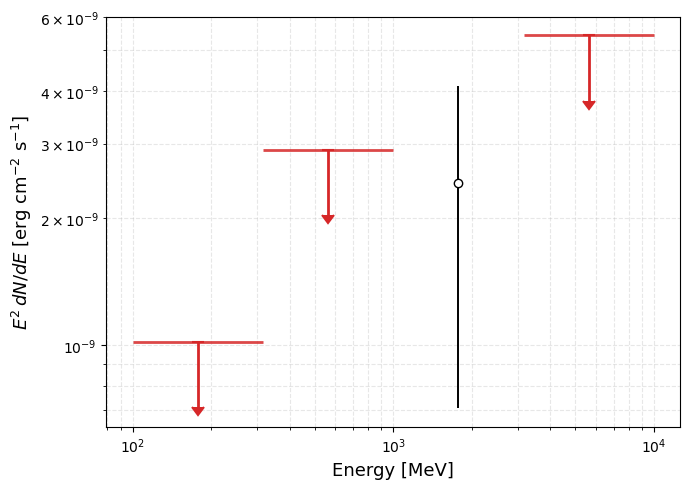

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from UpperLimits import UpperLimits
from LikelihoodState import LikelihoodState

# --- inputs you already have ---
SRC   = SRC_NAME
edges = np.array([100, 316, 1_000, 3_162, 10_000], float)   # MeV
Gamma = 2.0  # fixed spectral index in each bin (PL2 raw +Γ, scale -1 → physical −Γ)

# --- fix spectral index once (if present) ---
try:
    pidx = like_grb.model[SRC].funcs['Spectrum'].getParam('Index')
    pidx.setValue(float(Gamma))   # raw +Γ; with scale -1 this means physical −Γ
    pidx.setFree(False)
    like_grb.syncSrcParams(SRC)
except Exception:
    pass

# --- helpers (no E0 needed) ---
def e2dnde_from_band_flux(Fband, E1, E2, Eref, gamma):
    """Convert integrated photon flux over [E1,E2] for PL2(Γ) into E^2 dN/dE at Eref."""
    if not np.isfinite(Fband) or Fband <= 0:
        return np.nan
    if abs(gamma - 1.0) > 1e-12:
        return Fband * (1.0 - gamma) * (Eref**(2.0 - gamma)) / (E2**(1.0 - gamma) - E1**(1.0 - gamma))
    # gamma == 1 limit
    return Fband * Eref / np.log(E2/E1)

MeV_to_erg = 1.602176634e-6




# --- freeze diffuse indices (norms still free) ---
def freeze_diffuse_indices(like):
    for s in like.sourceNames():
        sl = s.lower()
        if ('iso' in sl) or ('gll_iem' in sl) or ('gal' in sl):
            try:
                sp = like.model[s].funcs['Spectrum']
                # keep norm free; just lock spectral slope if present
                for nm in ('Index','Gamma'):
                    try: sp.getParam(nm).setFree(False)
                    except Exception: pass
            except Exception:
                pass
    like.syncSrcParams()

freeze_diffuse_indices(like_grb)   # ← call this once before the bin loop





# --- snapshot + setup UL helper ---
state0 = LikelihoodState(like_grb)
full_bounds = like_grb.observation.roiCuts().getEnergyCuts()
UL = UpperLimits(like_grb)

# arrays for plotting
pt_x, pt_y, pt_yerr = [], [], []
ul_x, ul_y, ul_e1, ul_e2 = [], [], [], []

rows = []  # keep your tabular record too





for e1, e2 in zip(edges[:-1], edges[1:]):
    E1, E2 = float(e1), float(e2)
    Eref = np.sqrt(E1*E2)

    print(f"[SED bin] {E1:.0f}-{E2:.0f} MeV")
    like_grb.setEnergyRange(E1, E2)

    # settle nuisances in-band
    try:
        like_grb.fit(verbosity=0, optimizer="NEWMINUIT", covar=True)
    except Exception:
        like_grb.fit(verbosity=0, optimizer="NEWMINUIT", covar=False)

    # per-bin TS
    try:
        TS_bin = float(like_grb.Ts(SRC))
    except Exception:
        TS_bin = np.nan

    # band MLE photon flux
    try:
        F_mle = float(like_grb.flux(SRC, emin=E1, emax=E2))
    except Exception:
        F_mle = np.nan

    # decide: point vs UL
    if np.isfinite(TS_bin) and TS_bin >= 9.0 and np.isfinite(F_mle) and (F_mle > 0):
        # detection → point with optional error bar
        y = e2dnde_from_band_flux(F_mle, E1, E2, Eref, Gamma)          # MeV cm^-2 s^-1
        y_erg = y * MeV_to_erg

        # try to get 1σ on band flux and propagate to E^2 dN/dE
        yerr_erg = None
        try:
            Ferr = float(like_grb.fluxError(SRC, emin=E1, emax=E2))  # may not exist in some builds
            if np.isfinite(Ferr) and Ferr > 0:
                y_plus = e2dnde_from_band_flux(F_mle + Ferr, E1, E2, Eref, Gamma)
                yerr_erg = abs(y_plus - y) * MeV_to_erg
        except Exception:
            pass

        pt_x.append(Eref)
        pt_y.append(y_erg)
        pt_yerr.append(yerr_erg if (yerr_erg is not None) else 0.0)

        rows.append(dict(Emin=E1, Emax=E2, TS=TS_bin, Flux_MLE=F_mle,
                         Kind="point", E2dnde=y_erg, UL95=np.nan))
        print(f"  TS={TS_bin:.2f}  Flux_MLE={F_mle:.3e}  point E2dN/dE={y_erg:.3e} [erg cm^-2 s^-1]")

    else:
        # not significant → UL
        UL[SRC].compute(emin=E1, emax=E2, verbosity=0)
        try:
            ul95 = float(getattr(UL[SRC].results[0], "value"))
            UL[SRC].results.clear()
        except Exception:
            ul95 = np.nan

        if np.isfinite(ul95) and ul95 > 0:
            y95 = e2dnde_from_band_flux(ul95, E1, E2, Eref, Gamma) * MeV_to_erg
            ul_x.append(Eref); ul_y.append(y95); ul_e1.append(E1); ul_e2.append(E2)
            rows.append(dict(Emin=E1, Emax=E2, TS=TS_bin, Flux_MLE=F_mle,
                             Kind="UL", E2dnde=np.nan, UL95=ul95))
            print(f"  TS={TS_bin if np.isfinite(TS_bin) else np.nan:.2f}  UL95={ul95:.3e} → E2dN/dE(UL)={y95:.3e}")
        else:
            rows.append(dict(Emin=E1, Emax=E2, TS=TS_bin, Flux_MLE=F_mle,
                             Kind="UL", E2dnde=np.nan, UL95=np.nan))
            print("  UL95 unavailable (NaN).")

    # restore
    state0.restore()
    like_grb.setEnergyRange(*full_bounds)

# --------------------
# Plot: points + UL arrows + horizontal caps
# --------------------
plt.figure(figsize=(7,5))

# UL horizontal caps across each bin and down-arrows at Eref
for x, y, e1, e2 in zip(ul_x, ul_y, ul_e1, ul_e2):
    plt.hlines(y, e1, e2, color='tab:red', lw=2, alpha=0.85)
    plt.errorbar([x], [y], yerr=[0.3*y], fmt='none', uplims=True,
                 ecolor='tab:red', elinewidth=2, capsize=4, capthick=1.5)

# detection points (with optional 1σ)
if len(pt_x):
    yerr = np.array(pt_yerr, float)
    has_err = np.isfinite(yerr) & (yerr > 0)
    if np.any(has_err):
        plt.errorbar(np.array(pt_x)[has_err], np.array(pt_y)[has_err],
                     yerr=yerr[has_err], fmt='o', ms=6, mec='k',
                     mfc='white', ecolor='k', elinewidth=1.4, label='Detection (1σ)')
    if np.any(~has_err):
        plt.plot(np.array(pt_x)[~has_err], np.array(pt_y)[~has_err],
                 'o', ms=6, mfc='white', mec='k', label='Detection')

plt.xscale('log'); plt.yscale('log')
plt.xlabel("Energy [MeV]", fontsize=13)
plt.ylabel(r"$E^2\,dN/dE$ [erg cm$^{-2}$ s$^{-1}$]", fontsize=13)
plt.grid(True, which='both', ls='--', alpha=0.3)
plt.tight_layout()
plt.show()



==== Global Broadband Fit Results ====
TS_global       = 25.046
Flux_global     = 4.123e-06 ph/cm^2/s (E=100–10000 MeV)
Index_global    = -1.688

[SED bin] 100-316 MeV
  UL:  TS=0.18  UL95=6.031e-06  E^2 dN/dE(UL)=1.414e-09
[SED bin] 316-1000 MeV
  UL:  TS=8.42  UL95=4.903e-06  E^2 dN/dE(UL)=3.629e-09
[SED bin] 1000-3162 MeV
  DET: TS=22.15  Γ≈1.69  Flux=1.017e-06  E^2 dN/dE=2.452e-09 [erg cm^-2 s^-1]
[SED bin] 3162-10000 MeV
  UL:  TS=-0.00  UL95=8.360e-07  E^2 dN/dE(UL)=6.194e-09

Wrote /Users/salim/Desktop/MGFs_LAT/MGF_LAT_analysis_trigger/MGF_Stacking_Analysis/GRB_200415A_SED_points.csv


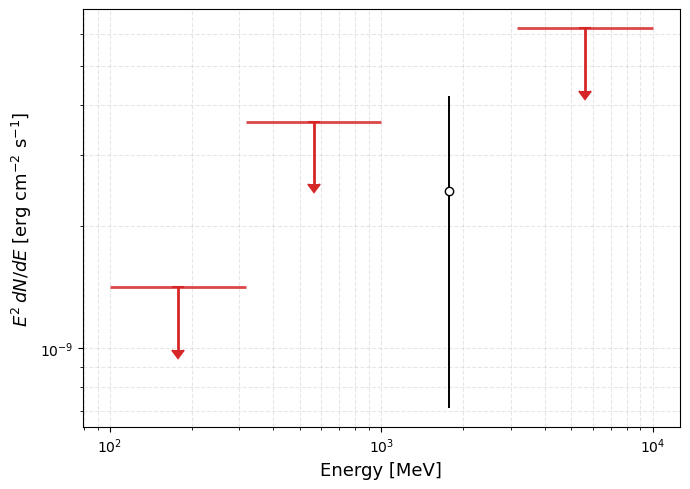

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from UpperLimits import UpperLimits
from LikelihoodState import LikelihoodState

# --- inputs you already have ---
SRC   = SRC_NAME
edges = np.array([100, 316, 1_000, 3_162, 10_000], float)   # MeV
Gamma = 2.0  # for ULs: PL2 raw +Γ, scale -1 → physical −Γ
MeV_to_erg = 1.602176634e-6

# --- helpers ---
def e2dnde_from_band_flux(Fband, E1, E2, Eref, gamma_pos):
    """PL2 with physical index gamma_pos>0: dN/dE ∝ E^{-gamma_pos}; return E^2 dN/dE at Eref (MeV cm^-2 s^-1)."""
    if not np.isfinite(Fband) or Fband <= 0:
        return np.nan
    if abs(gamma_pos - 1.0) > 1e-12:
        return Fband * (1.0 - gamma_pos) * (Eref**(2.0 - gamma_pos)) / (E2**(1.0 - gamma_pos) - E1**(1.0 - gamma_pos))
    return Fband * Eref / np.log(E2/E1)

def freeze_diffuse_indices(like):
    """Keep diffuse norms free; freeze their slopes (Index/Gamma) if present."""
    for s in like.sourceNames():
        sl = s.lower()
        if ('iso' in sl) or ('gll_iem' in sl) or ('gal' in sl):
            try:
                sp = like.model[s].funcs['Spectrum']
                for nm in ('Index','Gamma'):
                    try: sp.getParam(nm).setFree(False)
                    except Exception: pass
            except Exception:
                pass
    like.syncSrcParams()

def get_gamma_pos(like, src, default=2.0):
    """Return positive physical Γ from current model; fallback to default."""
    try:
        p = like.model[src].funcs['Spectrum'].getParam('Index')
        # getTrueValue accounts for scale (often -1), so take abs for Γ>0
        return abs(float(getattr(p, "getTrueValue", lambda: p.getValue()*(p.getScale() or 1.0))()))
    except Exception:
        return float(default)

# --- fix source Index initially (allowed to float later) ---
try:
    pidx = like_grb.model[SRC].funcs['Spectrum'].getParam('Index')
    pidx.setValue(float(Gamma))   # raw +Γ; with scale -1 this is physical −Γ
    pidx.setFree(True)
    like_grb.syncSrcParams(SRC)
except Exception:
    pass

# --- freeze diffuse slopes (norms free) ---
freeze_diffuse_indices(like_grb)

# --- GLOBAL broadband fit first ---
try:
    like_grb.fit(verbosity=0, optimizer="NEWMINUIT", covar=True)
except Exception:
    like_grb.fit(verbosity=0, optimizer="NEWMINUIT", covar=False)

# --- global stats ---
Elo, Ehi = float(edges[0]), float(edges[-1])
try:
    TS_global = float(like_grb.Ts(SRC))
except Exception:
    TS_global = np.nan
try:
    Flux_global = float(like_grb.flux(SRC, emin=Elo, emax=Ehi))
except Exception:
    Flux_global = np.nan
Index_global = get_gamma_pos(like_grb, SRC, default=Gamma) * (-1.0)  # report physical signed index if you like

print("\n==== Global Broadband Fit Results ====")
print(f"TS_global       = {TS_global:.3f}")
print(f"Flux_global     = {Flux_global:.3e} ph/cm^2/s (E={Elo:.0f}–{Ehi:.0f} MeV)")
print(f"Index_global    = {Index_global:.3f}")
print("=====================================\n")

Gamma_global_pos = get_gamma_pos(like_grb, SRC, default=Gamma)
# --- snapshot AFTER the global fit + UL helper ---
state0 = LikelihoodState(like_grb)
full_bounds = like_grb.observation.roiCuts().getEnergyCuts()
UL = UpperLimits(like_grb)

# --- arrays for plotting + rows for CSV ---
pt_x, pt_y, pt_yerr = [], [], []
ul_x, ul_y, ul_e1, ul_e2 = [], [], [], []
rows = []

# ------------------------ per-bin loop ------------------------
for e1, e2 in zip(edges[:-1], edges[1:]):
    E1, E2 = float(e1), float(e2)
    Eref = np.sqrt(E1*E2)

    print(f"[SED bin] {E1:.0f}-{E2:.0f} MeV")
    like_grb.setEnergyRange(E1, E2)

    # let Index float in the in-band fit
    try:
        pidx = like_grb.model[SRC].funcs['Spectrum'].getParam('Index')
        sc   = pidx.getScale() or 1.0         # often -1
        pidx.setValue(Gamma_global_pos / sc)  # raw +Γ if scale=-1 → physical −Γ
        pidx.setFree(False)
        like_grb.syncSrcParams(SRC)
        print(f"Index set to global value (Γ={Gamma_global_pos:.2f})")
    except Exception:
        pass

    # in-band fit
    try:
        like_grb.fit(verbosity=0, optimizer="NEWMINUIT", covar=True)
    except Exception:
        like_grb.fit(verbosity=0, optimizer="NEWMINUIT", covar=False)

    # read TS, flux
    try:
        TS_bin = float(like_grb.Ts(SRC))
    except Exception:
        TS_bin = np.nan
    try:
        F_mle = float(like_grb.flux(SRC, emin=E1, emax=E2))
    except Exception:
        F_mle = np.nan

    if np.isfinite(TS_bin) and TS_bin >= 9.0 and np.isfinite(F_mle) and (F_mle > 0):
        # detection: use fitted Γ for conversion
        gamma_pos = Gamma_global_pos   # use the global Γ you just froze to
        y_mev  = e2dnde_from_band_flux(F_mle, E1, E2, Eref, gamma_pos)
        y_erg  = y_mev * MeV_to_erg

        # 1σ flux error if available
        try:
            Ferr = float(like_grb.fluxError(SRC, emin=E1, emax=E2))
        except Exception:
            Ferr = np.nan
        yerr_erg = 0.0
        if np.isfinite(Ferr) and Ferr > 0:
            y_plus = e2dnde_from_band_flux(F_mle + Ferr, E1, E2, Eref, gamma_pos)
            yerr_erg = abs(y_plus - y_mev) * MeV_to_erg

        pt_x.append(Eref); pt_y.append(y_erg); pt_yerr.append(yerr_erg)

        rows.append(dict(
            Emin=E1, Emax=E2, Eref=Eref,
            TS_local=TS_bin, TS_global=TS_global, det_flag=1,
            Index_used=gamma_pos, Index_err=np.nan,  # you can add pidx.error() if desired
            Flux_MLE=F_mle, FluxErr=Ferr,
            UL95=np.nan,
            E2dnde_erg=y_erg, E2dnde_UL_erg=np.nan
        ))
        print(f"  DET: TS={TS_bin:.2f}  Γ≈{gamma_pos:.2f}  Flux={F_mle:.3e}  E^2 dN/dE={y_erg:.3e} [erg cm^-2 s^-1]")

    else:
        # UL path: restore to clean global state BEFORE fixing Γ=2 and computing UL
        state0.restore()
        like_grb.setEnergyRange(E1, E2)

        try:
            pidx = like_grb.model[SRC].funcs['Spectrum'].getParam('Index')
            pidx.setValue(float(Gamma))  # raw +Γ; scale -1 ⇒ physical −Γ
            pidx.setFree(False)
            like_grb.syncSrcParams(SRC)
        except Exception:
            pass

        # compute UL
        UL[SRC].compute(emin=E1, emax=E2, verbosity=0)  # add nsigmax=3, renorm=True if ever touchy
        try:
            ul95 = float(getattr(UL[SRC].results[0], "value"))
            UL[SRC].results.clear()
        except Exception:
            ul95 = np.nan

        y95_erg = np.nan
        if np.isfinite(ul95) and ul95 > 0:
            y95_mev = e2dnde_from_band_flux(ul95, E1, E2, Eref, Gamma)
            y95_erg = y95_mev * MeV_to_erg
            ul_x.append(Eref); ul_y.append(y95_erg); ul_e1.append(E1); ul_e2.append(E2)

        rows.append(dict(
            Emin=E1, Emax=E2, Eref=Eref,
            TS_local=TS_bin, TS_global=TS_global, det_flag=0,
            Index_used=Gamma, Index_err=np.nan,
            Flux_MLE=np.nan, FluxErr=np.nan,
            UL95=ul95,
            E2dnde_erg=np.nan, E2dnde_UL_erg=y95_erg
        ))
        print(f"  UL:  TS={TS_bin if np.isfinite(TS_bin) else np.nan:.2f}  UL95={ul95:.3e}  E^2 dN/dE(UL)={y95_erg:.3e}")

    # restore for next bin
    state0.restore()
    like_grb.setEnergyRange(*full_bounds)

# -------- save CSV --------
df = pd.DataFrame(rows)
csv_path = Path("GRB_200415A_SED_points.csv")
df.to_csv(csv_path, index=False)
print(f"\nWrote {csv_path.resolve()}")

# -------- plot --------
plt.figure(figsize=(7,5))
for x, y, e1, e2 in zip(ul_x, ul_y, ul_e1, ul_e2):
    if np.isfinite(y) and y > 0:
        plt.hlines(y, e1, e2, lw=2, alpha=0.85, color='tab:red')
        plt.errorbar([x], [y], yerr=[0.3*y], fmt='none', uplims=True,
                     ecolor='tab:red', elinewidth=2, capsize=4, capthick=1.5)

if len(pt_x):
    yerr = np.array(pt_yerr, float)
    has_err = np.isfinite(yerr) & (yerr > 0)
    if np.any(has_err):
        plt.errorbar(np.array(pt_x)[has_err], np.array(pt_y)[has_err],
                     yerr=yerr[has_err], fmt='o', ms=6, mec='k',
                     mfc='white', ecolor='k', elinewidth=1.4, label='Detection (1σ)')
    if np.any(~has_err):
        plt.plot(np.array(pt_x)[~has_err], np.array(pt_y)[~has_err],
                 'o', ms=6, mfc='white', mec='k', label='Detection')

plt.xscale('log'); plt.yscale('log')
plt.xlabel("Energy [MeV]", fontsize=13)
plt.ylabel(r"$E^2\,dN/dE$ [erg cm$^{-2}$ s$^{-1}$]", fontsize=13)
plt.grid(True, which='both', ls='--', alpha=0.3)
plt.tight_layout()
plt.show()


# Get SED profile scan

[SED bin] 100-316 MeV
[SED bin] 316-1000 MeV
[SED bin] 1000-3162 MeV
[SED bin] 3162-10000 MeV
[100-316 MeV] TS=0.10  E^2 dN/dE UL=1.013e-09 erg cm^-2 s^-1
[316-1000 MeV] TS=8.02  E^2 dN/dE UL=2.897e-09 erg cm^-2 s^-1
[1000-3162 MeV] TS=15.53  E^2 dN/dE UL=6.387e-09 erg cm^-2 s^-1
[3162-10000 MeV] TS=0.00  E^2 dN/dE UL=5.417e-09 erg cm^-2 s^-1


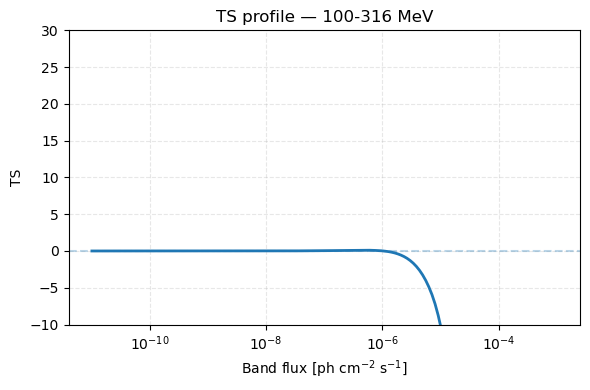

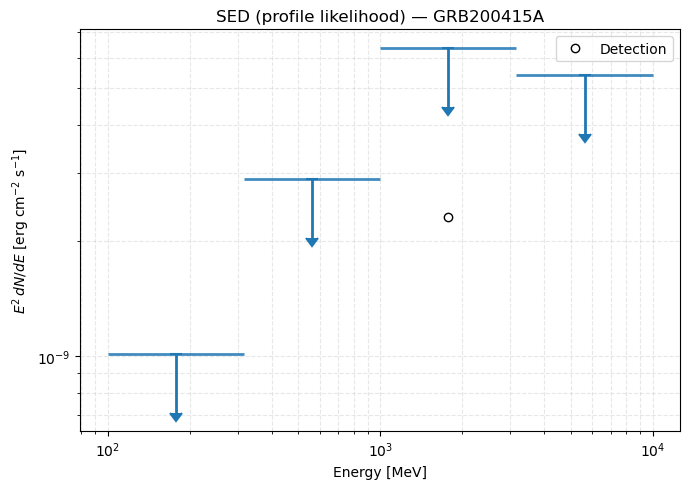

In [12]:
# ====== PROFILE HELPERS (final fixed version) ======
from LikelihoodState import LikelihoodState
import numpy as np
import matplotlib.pyplot as plt

# --- config ---
PROFILE_CONFIG = {
    "flux_grid": np.concatenate(([0.0], np.logspace(-11, -3, 150))),
    "delta_chi2_95": 2.71,
}

# --- helpers ---
def _freeze_all_params(like):
    npars = len(like.model.params)
    for k in range(npars):
        try:
            like.freeze(k)
        except Exception:
            pass
    like.syncSrcParams()  # ← add this

def _free_diffuse_norms(like):
    for s in like.sourceNames():
        sl = s.lower()
        if ('iso' in sl) or ('gll_iem' in sl) or ('gal' in sl):
            try:
                spec = like.model[s].funcs['Spectrum']
            except Exception:
                continue
            for pname in ('Prefactor', 'Normalization', 'Value', 'norm'):
                try:
                    spec.getParam(pname).setFree(True)
                    break
                except Exception:
                    continue
            try:
                spec.getParam('Index').setFree(False)
            except Exception:
                pass
    like.syncSrcParams()


def _safe_set_bounds_include_value(p, x_stored, lo_floor=None):
    lo, hi = p.getBounds()
    new_lo = min(lo, x_stored)
    new_hi = max(hi, x_stored)
    if (lo_floor is not None) and (new_lo < lo_floor):
        new_lo = lo_floor
        if x_stored < new_lo:
            new_lo = x_stored
    if (new_lo, new_hi) != (lo, hi):
        p.setBounds(new_lo, new_hi)

def _prepare_transient_pl2(like, src):
    spec = like.model[src].funcs['Spectrum']
    for nm in ('Index', 'LowerLimit', 'UpperLimit'):
        try:
            spec.getParam(nm).setFree(False)
        except Exception:
            pass
    P = spec.getParam('Integral')
    sc = P.getScale() or 1.0
    _safe_set_bounds_include_value(P, P.getValue(), lo_floor=0.0)
    P.setFree(False)
    like.syncSrcParams(src)

def _set_flux(like, flux, src):
    spec = like.model[src].funcs['Spectrum']
    P = spec.getParam('Integral')
    sc = P.getScale() or 1.0
    x = max(0.0, float(flux)) / sc
    _safe_set_bounds_include_value(P, x, lo_floor=0.0)
    P.setValue(x)
    P.setFree(False)
    like.syncSrcParams(src)

def _set_pl2_band(like, src, E1, E2):
    spec = like.model[src].funcs['Spectrum']
    for name, val in (('LowerLimit', float(E1)), ('UpperLimit', float(E2))):
        try:
            p = spec.getParam(name)
            p.setValue(val / (p.getScale() or 1.0))
            p.setFree(False)
        except Exception:
            pass
    like.syncSrcParams(src)


def prepare_for_profile(like, src):
    _freeze_all_params(like)
    _free_diffuse_norms(like)
    _prepare_transient_pl2(like, src)


# --- TS-based UL helper (FXT v2 style) ---
def calculate_95_upper_limit(flux_grid, test_statistic, method='right_side', delta_ts=2.71):
    valid = np.isfinite(test_statistic)
    if not np.any(valid):
        return {'upper_limit': None, 'best_fit': None, 'max_ts': np.nan,
                'ts_threshold': np.nan, 'method': method}

    F  = flux_grid[valid]
    TS = test_statistic[valid]
    idx_max = int(np.argmax(TS))
    TSmax   = TS[idx_max]
    Fhat    = F[idx_max]
    ts_thr  = TSmax - float(delta_ts)

    UL = None
    if method == 'right_side':
        right = F > Fhat
        if np.any(right):
            Fr, TSr = F[right], TS[right]
            crossed = np.where(TSr <= ts_thr)[0]
            if len(crossed) > 0:
                j = crossed[0]
                if j > 0:
                    f1, f2 = Fr[j-1], Fr[j]
                    t1, t2 = TSr[j-1], TSr[j]
                    if (f1 > 0) and (f2 > 0) and (t2 != t1):
                        w  = (ts_thr - t1) / (t2 - t1)
                        UL = 10**(np.log10(f1) + w*(np.log10(f2) - np.log10(f1)))
                else:
                    UL = Fr[0]

    return {'upper_limit': UL, 'best_fit': Fhat, 'max_ts': TSmax,
            'ts_threshold': ts_thr, 'method': method}


# --- Convert flux to E^2 dN/dE ---
def _K_from_band_flux(Fband, E1, E2, gamma_mag, Eref):
    if not np.isfinite(Fband) or Fband <= 0:
        return np.nan
    if abs(gamma_mag - 1.0) > 1e-12:
        denom = (E2**(1.0 - gamma_mag) - E1**(1.0 - gamma_mag))
        if denom == 0:
            return np.nan
        return Fband * (1.0 - gamma_mag) / ((Eref**gamma_mag) * denom)
    return Fband / (Eref * np.log(E2/E1))


# --- main scan function ---
def sed_profile_scan_bins(like, src, edges, gamma_fixed_mag=2.0):
    spec = like.model[src].funcs['Spectrum']

    # freeze the spectral index to -|gamma_fixed_mag|
    try:
        pidx = spec.getParam("Index")
        pidx.setValue((-abs(gamma_fixed_mag)) / (pidx.getScale() or 1.0))
        pidx.setFree(False)
        like.syncSrcParams(src)
    except Exception:
        pass

    state_global = LikelihoodState(like)
    full_bounds  = like.observation.roiCuts().getEnergyCuts()

    out = dict(Emin=[], Emax=[], Eref=[], TS=[], Fhat=[], UL95=[],
               E2dnde=[], E2dnde_UL=[], E2dnde_erg=[], E2dnde_UL_erg=[])
    profiles = []

    for ibin, (E1, E2) in enumerate(zip(edges[:-1], edges[1:])):
        E1, E2 = float(E1), float(E2)
        Eref   = float(np.sqrt(E1*E2))
        print(f"[SED bin] {E1:.0f}-{E2:.0f} MeV")

        state_bin = LikelihoodState(like)
        like.setEnergyRange(E1, E2)
        _set_pl2_band(like, src, E1, E2)
        prepare_for_profile(like, src)

        # null hypothesis
        _set_flux(like, 0.0, src=src)
        try:
            like.fit(verbosity=0, optimizer="NEWMINUIT", covar=False)
        except Exception:
            pass
        logL0 = -float(like())

        # scan flux grid
        Fgrid = PROFILE_CONFIG["flux_grid"].astype(float)
        Lgrid = np.full_like(Fgrid, np.nan, dtype=float)
        for j, F in enumerate(Fgrid):
            _set_flux(like, F, src=src)
            try:
                like.fit(verbosity=0, optimizer="NEWMINUIT", covar=False)
                Lgrid[j] = -float(like())
            except Exception:
                Lgrid[j] = np.nan

        # TS profile & UL
        TSgrid = 2.0 * (Lgrid - logL0)
        ul = calculate_95_upper_limit(Fgrid, TSgrid,
                                      method='right_side',
                                      delta_ts=PROFILE_CONFIG.get('delta_chi2_95', 2.71))
        UL, Fhat, TSbin = ul['upper_limit'], ul['best_fit'], ul['max_ts']
        TSbin = max(TSbin, 0.0) if np.isfinite(TSbin) else 0.0

        # convert to E^2 dN/dE
        gamma_mag = abs(gamma_fixed_mag)
        K_mle = _K_from_band_flux(Fhat, E1, E2, gamma_mag, Eref) if (np.isfinite(Fhat) and Fhat>0) else np.nan
        K_ul  = _K_from_band_flux(UL,   E1, E2, gamma_mag, Eref) if (UL is not None and np.isfinite(UL) and UL>0) else np.nan
        e2_mle = (Eref**2) * K_mle if np.isfinite(K_mle) else np.nan
        e2_ul  = (Eref**2) * K_ul  if np.isfinite(K_ul)  else np.nan
        to_erg = 1.602176634e-6

        # store
        out['Emin'].append(E1); out['Emax'].append(E2); out['Eref'].append(Eref)
        out['TS'].append(TSbin); out['Fhat'].append(Fhat); out['UL95'].append(UL if UL is not None else np.nan)
        out['E2dnde'].append(e2_mle); out['E2dnde_UL'].append(e2_ul)
        out['E2dnde_erg'].append(e2_mle*to_erg if np.isfinite(e2_mle) else np.nan)
        out['E2dnde_UL_erg'].append(e2_ul*to_erg if np.isfinite(e2_ul) else np.nan)
        profiles.append((E1, E2, Fgrid, TSgrid))

        state_bin.restore()
        like.setEnergyRange(*full_bounds)

    for k in out:
        out[k] = np.asarray(out[k], float)

    state_global.restore()
    like.setEnergyRange(*full_bounds)
    return out, profiles


# --- plotting helpers ---
def plot_ts_profile_for_bin(profiles, ibin, ymin=None, ymax=None):
    e1, e2, Fgrid, TSgrid = profiles[ibin]
    m = Fgrid > 0
    plt.figure(figsize=(6,4))
    plt.semilogx(Fgrid[m], TSgrid[m], lw=2)
    plt.axhline(0, ls='--', alpha=0.3)
    plt.xlabel("Band flux [ph cm$^{-2}$ s$^{-1}$]"); plt.ylabel("TS")
    plt.title(f"TS profile — {e1:.0f}-{e2:.0f} MeV")
    if ymin is not None and ymax is not None:
        plt.ylim(ymin, ymax)
    plt.grid(True, which='both', ls='--', alpha=0.3)
    plt.tight_layout(); plt.show()

def plot_sed_caps(out, title="SED (profile likelihood)"):
    E1, E2, Eref = out['Emin'], out['Emax'], out['Eref']
    y_ul, y_pt, TS = out['E2dnde_UL_erg'], out['E2dnde_erg'], out['TS']
    plt.figure(figsize=(7,5))
    for e1, e2, x, y in zip(E1, E2, Eref, y_ul):
        if np.isfinite(y) and y>0:
            plt.hlines(y, e1, e2, lw=2, alpha=0.85)
            plt.errorbar([x],[y],yerr=[0.3*y],fmt='none',uplims=True,
                         elinewidth=2,capsize=4,capthick=1.5)
    det = (TS>=9.0) & np.isfinite(y_pt) & (y_pt>0)
    if np.any(det):
        plt.plot(Eref[det], y_pt[det], 'o', ms=6, mfc='white', mec='k', label='Detection')
        plt.legend()
    plt.xscale('log'); plt.yscale('log')
    plt.xlabel("Energy [MeV]"); plt.ylabel(r"$E^2\,dN/dE$ [erg cm$^{-2}$ s$^{-1}$]")
    plt.title(title); plt.grid(True, which='both', ls='--', alpha=0.3)
    plt.tight_layout(); plt.show()
# ====== END HELPERS ======


# --- Example execution ---
edges = np.array([100, 316, 1000, 3162, 10000], float)

out, profiles = sed_profile_scan_bins(like_grb, src=SRC_NAME, edges=edges, gamma_fixed_mag=2.0)

for e1, e2, ts, ul in zip(out['Emin'], out['Emax'], out['TS'], out['E2dnde_UL_erg']):
    print(f"[{e1:.0f}-{e2:.0f} MeV] TS={ts:.2f}  E^2 dN/dE UL={ul:.3e} erg cm^-2 s^-1")

plot_ts_profile_for_bin(profiles, ibin=0, ymin=-10, ymax=30)
plot_sed_caps(out, title=f"SED (profile likelihood) — {SRC_NAME}")


In [13]:
# Comparision

In [14]:
def compute_sed_upperlimits(like, src, edges, gamma_fixed=2.0):
    """
    Compute per-bin SED using Fermitools UpperLimits (Method 1).
    Returns a dict with lists of Emin, Emax, Eref, TS, flux_MLE, flux_UL, E2dnde_MLE, E2dnde_UL.
    Flux is in ph/cm^2/s, E2dnde in MeV cm^-2 s^-1 (multiply by MeV_to_erg for erg).
    """
    import numpy as np
    from UpperLimits import UpperLimits
    from LikelihoodState import LikelihoodState

    # Fix spectral index if present
    try:
        spec = like.model[src].funcs['Spectrum']
        pidx = spec.getParam('Index')
        pidx.setValue(gamma_fixed)
        pidx.setFree(False)
        like.syncSrcParams(src)
    except Exception:
        pass



    # --- freeze diffuse indices (norms still free) ---
    def freeze_diffuse_indices(like):
        for s in like.sourceNames():
            sl = s.lower()
            if ('iso' in sl) or ('gll_iem' in sl) or ('gal' in sl):
                try:
                    sp = like.model[s].funcs['Spectrum']
                    # keep norm free; just lock spectral slope if present
                    for nm in ('Index','Gamma'):
                        try: sp.getParam(nm).setFree(False)
                        except Exception: pass
                except Exception:
                    pass
        like.syncSrcParams()

    freeze_diffuse_indices(like)   # ← call this once before the bin loop

    # Snapshot and full-energy bounds
    state0 = LikelihoodState(like)
    full_bounds = like.observation.roiCuts().getEnergyCuts()
    ULtool = UpperLimits(like)
    MeV_to_erg = 1.602176634e-6

    # Prepare output structure
    out = {'Emin':[], 'Emax':[], 'Eref':[],
           'TS':[], 'flux_MLE':[], 'flux_UL':[], 'E2dnde_MLE':[], 'E2dnde_UL':[],
           'E2dnde_MLE_erg':[], 'E2dnde_UL_erg':[]}

    for e1, e2 in zip(edges[:-1], edges[1:]):
        E1, E2 = float(e1), float(e2)
        Eref = np.sqrt(E1 * E2)
        out['Emin'].append(E1)
        out['Emax'].append(E2)
        out['Eref'].append(Eref)

        like.setEnergyRange(E1, E2)
        # Fit with source free to get TS and MLE flux
        try:
            like.fit(verbosity=0, optimizer="NEWMINUIT", covar=True)
        except Exception:
            like.fit(verbosity=0, optimizer="NEWMINUIT", covar=False)

        # Compute TS and MLE flux
        try:
            TSbin = float(like.Ts(src))
        except Exception:
            TSbin = np.nan
        out['TS'].append(TSbin)

        try:
            flux_mle = float(like.flux(src, emin=E1, emax=E2))
        except Exception:
            flux_mle = np.nan
        out['flux_MLE'].append(flux_mle)

        # Compute 95% UL via UpperLimits class (photon flux)
        ULtool[src].compute(emin=E1, emax=E2)
        ul_last = ULtool[src].results[0]
        ul95 = getattr(ul_last, "value", np.nan)   # flux UL [ph/cm^2/s]
        out['flux_UL'].append(ul95)
        ULtool[src].results.clear()
        

        # Convert flux values to E^2 dN/dE at Eref
        def K_from_band_flux(Fband, E1, E2, E0, gamma):
            # K such that dN/dE = K*(E/E0)^(-gamma); band flux -> normalization K
            if not np.isfinite(Fband) or Fband <= 0:
                return np.nan
            if abs(gamma - 1.0) > 1e-12:
                denom = (E2**(1.0 - gamma) - E1**(1.0 - gamma))
                if denom == 0:
                    return np.nan
                return Fband * (1.0 - gamma) / ((E0**gamma) * denom)
            return Fband / (E0 * np.log(E2/E1))

        def E2dnde_from_K(E0, K):  # returns MeV cm^-2 s^-1
            return (E0**2) * K

        K_mle = K_from_band_flux(flux_mle, E1, E2, Eref, gamma_fixed)
        K_ul  = K_from_band_flux(ul95,     E1, E2, Eref, gamma_fixed)
        y_mle = E2dnde_from_K(Eref, K_mle)
        y_ul  = E2dnde_from_K(Eref, K_ul)
        out['E2dnde_MLE'].append(y_mle)
        out['E2dnde_UL'].append(y_ul)
        out['E2dnde_MLE_erg'].append(y_mle * MeV_to_erg)
        out['E2dnde_UL_erg'].append(y_ul * MeV_to_erg)

        # Restore state and full bounds for next bin
        state0.restore()
        like.setEnergyRange(*full_bounds)

    return out


In [15]:
def compute_sed_profile_scan(like, src, edges, gamma_fixed=2.0):
    """
    Compute per-bin SED via profile-likelihood (Method 2).
    Returns the same structured dict as sed_profile_scan_bins plus the TS profiles.
    """
    # sed_profile_scan_bins is assumed defined (from the provided code).
    out, profiles = sed_profile_scan_bins(like, src, edges, gamma_fixed_mag=gamma_fixed)
    return out, profiles


In [16]:
# Assume like_grb, SRC_NAME, edges, Gamma are defined in the session
ul_result = compute_sed_upperlimits(like_grb, SRC_NAME, edges, gamma_fixed=Gamma)
prof_result, profiles = compute_sed_profile_scan(like_grb, SRC_NAME, edges, gamma_fixed=Gamma)

0 0.7413911708997745 0.0006353779798757841 5.072867025825691e-07
1 1.683444963414712 0.07124717855733564 1.1518740416526085e-06
2 2.6254987559296494 0.23759844786169282 1.7964613807226484e-06
3 3.5675525484445867 0.46657010341893823 2.441048719792687e-06
4 4.509606340959524 0.7402497834943205 3.085636058862727e-06
5 6.328545754437217 1.3586313158024979 4.330220312733359e-06
0 6.370837214442204 0.000595365402247694 1.3803999652598713e-06
1 8.400172450675612 0.06479846260591415 1.8201057990939096e-06
2 10.42950768690902 0.2321217655462533 2.259811632927948e-06
3 12.458842923142427 0.4679845228069439 2.6995174667619843e-06
4 14.488178159375835 0.7555084613431049 3.139223300596023e-06
5 18.147780822439884 1.3661433562736462 3.932167025089044e-06
0 15.05294390524714 -4.917714591101685e-08 1.0302785846875715e-06
1 19.31341870525 0.0692516875861422 1.3218810761785496e-06
2 23.57389350525286 0.2365332226036081 1.6134835676695282e-06
3 27.834368305255722 0.47170794241685243 1.9050860591605072e-

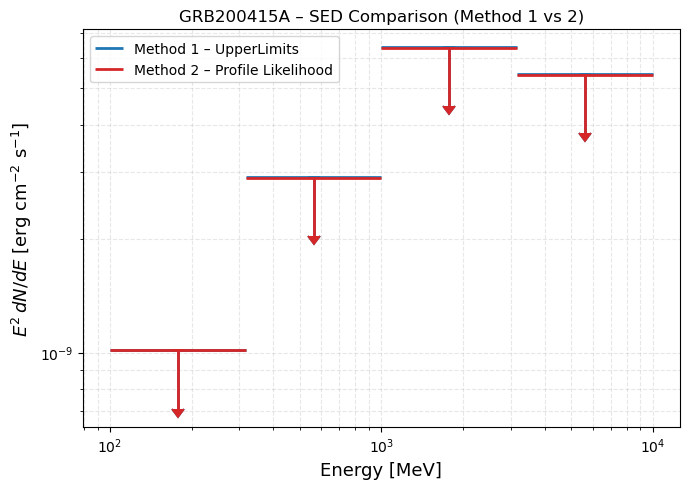

In [17]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(7,5))

# --- Method 1 (UpperLimits) ---
Eref1 = np.array(ul_result['Eref'])
Y1    = np.array(ul_result['E2dnde_UL_erg'])
plt.hlines(Y1, ul_result['Emin'], ul_result['Emax'],
           colors='tab:blue', lw=2, label='Method 1 – UpperLimits')
plt.errorbar(Eref1, Y1, yerr=0.3*Y1, fmt='none', uplims=True,
             ecolor='tab:blue', elinewidth=2, capsize=4, capthick=1.3)

# --- Method 2 (Profile scan) ---
Eref2 = np.array(prof_result['Eref'])
Y2    = np.array(prof_result['E2dnde_UL_erg'])
plt.hlines(Y2, prof_result['Emin'], prof_result['Emax'],
           colors='tab:red', lw=2, label='Method 2 – Profile Likelihood')
plt.errorbar(Eref2, Y2, yerr=0.3*Y2, fmt='none', uplims=True,
             ecolor='tab:red', elinewidth=2, capsize=4, capthick=1.3)

# axes & labels
plt.xscale('log'); plt.yscale('log')
plt.xlabel("Energy [MeV]", fontsize=13)
plt.ylabel(r"$E^2\,dN/dE$ [erg cm$^{-2}$ s$^{-1}$]", fontsize=13)
plt.grid(True, which='both', ls='--', alpha=0.3)
plt.legend()
plt.title(f"{SRC_NAME} – SED Comparison (Method 1 vs 2)")
plt.tight_layout()
plt.show()


# Plot TS Scan

In [18]:
def plot_ts_profile_fxstyle(Fgrid, TSgrid, title="Profile Likelihood", delta_ts=2.71):
    """FXT-style TS profile: best-fit, TSmax, TS-Δ, and 95% UL markers."""
    import numpy as np
    import matplotlib.pyplot as plt

    # Clean arrays
    m = np.isfinite(Fgrid) & np.isfinite(TSgrid) & (Fgrid > 0)
    if not np.any(m):
        print("No finite TS points to plot.")
        return

    F = np.array(Fgrid)[m]
    TS = np.array(TSgrid)[m]

    # Compute UL etc. with your helper
    ul = calculate_95_upper_limit(F, TS, method='right_side', delta_ts=delta_ts)
    Fhat = ul['best_fit']
    TSmax = ul['max_ts']
    thr = ul['ts_threshold']
    UL = ul['upper_limit']

    plt.figure(figsize=(6,4))
    plt.semilogx(F, TS, '-', lw=2, label='TS profile')
    plt.axhline(0, color='gray', ls='-', alpha=0.3)

    # Best-fit (vertical) & TSmax (horizontal)
    if np.isfinite(Fhat):
        plt.axvline(Fhat, color='green', ls='--', alpha=0.7,
                    label=f"Best fit: {Fhat:.2e}")
    if np.isfinite(TSmax):
        plt.axhline(TSmax, color='green', ls='--', alpha=0.7,
                    label=f"Max TS: {TSmax:.1f}")

    # Threshold TSmax-Δ (horizontal)
    if np.isfinite(thr):
        plt.axhline(thr, color='red', ls='--', alpha=0.7, label=f"TS − {delta_ts:.2f}")

    # 95% UL (vertical + dot at crossing)
    if UL is not None and np.isfinite(UL):
        plt.axvline(UL, color='red', ls=':', lw=2, label=f"95% UL: {UL:.2e}")
        if np.isfinite(thr):
            plt.plot(UL, thr, 'o', ms=7, color='red')

    plt.xlabel('Band flux [ph cm$^{-2}$ s$^{-1}$]')
    plt.ylabel('Test Statistic (TS)')
    plt.title(title)
    # Auto y-lims with some padding
    ylo = min(np.nanmin(TS), 0.0)
    yhi = np.nanmax(TS) if np.isfinite(np.nanmax(TS)) else 10.0
    plt.ylim(ylo - 0.1*abs(yhi-ylo), yhi + 0.25*abs(yhi-ylo))
    plt.grid(True, alpha=0.3)
    plt.legend(loc='best')
    plt.tight_layout()
    plt.ylim(-5, 30)
    plt.show()


In [19]:
def plot_ts_profile_from_profiles(profiles, ibin, delta_ts=2.71):
    item = profiles[ibin]
    if len(item) == 3:
        _, Fgrid, TSgrid = item
        title = f"TS profile — bin {ibin}"
    else:
        e1, e2, Fgrid, TSgrid = item
        title = f"TS profile — {e1:.0f}-{e2:.0f} MeV"
    plot_ts_profile_fxstyle(Fgrid, TSgrid, title=title, delta_ts=delta_ts)
    


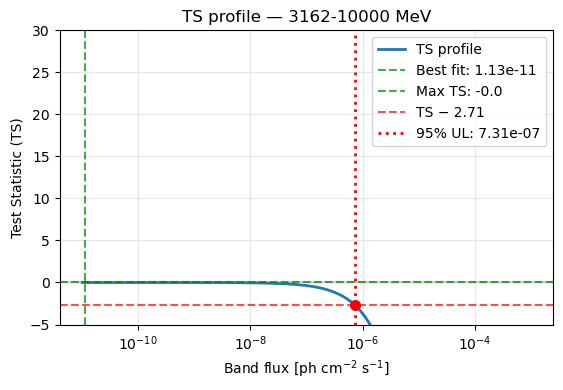

In [20]:
plot_ts_profile_from_profiles(profiles, ibin=3)  # pick any bin index
